# Import

In [1]:
import google.generativeai as genai
import pandas as pd
import time # To add delays between API calls and avoid rate limiting
from google.colab import userdata
api_key = userdata.get('GEMINI_API_KEY')
genai.configure(api_key=api_key)

In [2]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
full_df = pd.read_csv('/content/drive/MyDrive/final_articles_classified.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import math

# Analytics

In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707542 entries, 0 to 1707541
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   year                   int64  
 1   month                  int64  
 2   headline               object 
 3   lead_paragraph         object 
 4   news_desk              object 
 5   keywords               object 
 6   new                    object 
 7   is_womens_health_pred  int64  
 8   confidence_score       float64
dtypes: float64(1), int64(3), object(5)
memory usage: 117.2+ MB


In [5]:
df = full_df[full_df['is_womens_health_pred'] == True].copy()
df = df[~df['headline'].str.contains('Obituary|Paid Notice: Deaths|Correction|Film', case=False, na=False)].copy()
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35367 entries, 117 to 1707539
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   35367 non-null  int64  
 1   month                  35367 non-null  int64  
 2   headline               35367 non-null  object 
 3   lead_paragraph         35275 non-null  object 
 4   news_desk              31341 non-null  object 
 5   keywords               31325 non-null  object 
 6   new                    35367 non-null  object 
 7   is_womens_health_pred  35367 non-null  int64  
 8   confidence_score       35367 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 2.7+ MB


# Gemini API

In [6]:
model = genai.GenerativeModel('gemini-1.5-flash-latest')

#Function to get Themes
def get_theme_from_gemini(text):
    """
    Sends text to the Gemini API to extract a concise theme.
    Includes a retry mechanism to handle transient network errors.
    """
    prompt = f"""
    Analyze the following article text and provide a single, concise theme for it.
    The theme should be 2-4 words long (e.g., 'Corporate Acquisition', 'Political Debate', 'Tech Product Launch').

    ARTICLE TEXT: "{text}"

    THEME:
    """
    max_retries = 3
    delay = 2
    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
            return response.text.strip()
        except Exception as e:
            print(f"An error occurred: {e}. Retrying in {delay}s...")
            time.sleep(delay)
            delay *= 2
    return None

df['full_text'] = df['headline'] + " " + df['lead_paragraph']
texts_to_process = df['full_text'].tolist()

chunk_size = 1000  # Process 1000 rows at a time before saving
results = []
output_file = 'themed_articles_with_progress_v2.csv'

# Process the data in chunks
for i in tqdm(range(0, len(texts_to_process), chunk_size), desc="Processing Chunks"):
    chunk = texts_to_process[i:i + chunk_size]

    with Pool(processes=cpu_count()) as pool:
        chunk_results = list(tqdm(pool.imap(get_theme_from_gemini, chunk), total=len(chunk), desc=f"Chunk {i//chunk_size + 1}"))

    results.extend(chunk_results)

    temp_df = df.iloc[0:len(results)].copy()
    temp_df['gemini_theme'] = results
    temp_df.to_csv('/content/drive/My Drive/womens_themes.csv', index=False)
    print(f"\nProgress saved to {output_file}. Processed {len(results)} of {len(df)} rows.\n")

df['gemini_theme'] = results

Chunk 1:  29%|██▉       | 290/1000 [01:56<08:38,  1.37it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:   3%|▎         | 1/36 [06:37<3:51:53, 397.53s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 1000 of 35367 rows.




Chunk 2:  56%|█████▋    | 565/1000 [03:32<03:06,  2.33it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...


Chunk 2:  57%|█████▋    | 566/1000 [03:34<05:45,  1.26it/s]


Chunk 2:  57%|█████▋    | 572/1000 [03:39<05:01,  1.42it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Chunk 2:  57%|█████▋    | 573/1000 [03:42<08:16,  1.16s/it]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Chunk 2:  60%|█████▉    | 599/1000 [04:00<04:13,  1.58it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:   6%|▌         | 2/36 [13:09<3:43:25, 394.29s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 2000 of 35367 rows.




Processing Chunks:   8%|▊         | 3/36 [19:30<3:33:24, 388.01s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 3000 of 35367 rows.




Chunk 4:  93%|█████████▎| 929/1000 [05:58<00:41,  1.71it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  11%|█         | 4/36 [25:56<3:26:32, 387.25s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 4000 of 35367 rows.




Chunk 5:  39%|███▊      | 387/1000 [02:30<04:26,  2.30it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  14%|█▍        | 5/36 [32:29<3:21:12, 389.42s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 5000 of 35367 rows.




Processing Chunks:  17%|█▋        | 6/36 [39:04<3:15:36, 391.21s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 6000 of 35367 rows.




Chunk 7:  25%|██▍       | 248/1000 [01:41<07:36,  1.65it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  19%|█▉        | 7/36 [46:12<3:15:01, 403.49s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 7000 of 35367 rows.




Processing Chunks:  22%|██▏       | 8/36 [53:33<3:13:50, 415.38s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 8000 of 35367 rows.




Processing Chunks:  25%|██▌       | 9/36 [1:00:25<3:06:22, 414.15s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 9000 of 35367 rows.




Chunk 10:  22%|██▏       | 223/1000 [01:30<05:58,  2.17it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...


Chunk 10:  22%|██▏       | 224/1000 [01:31<10:15,  1.26it/s]


An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  28%|██▊       | 10/36 [1:07:11<2:58:28, 411.86s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 10000 of 35367 rows.




Chunk 11:  55%|█████▍    | 545/1000 [03:35<04:26,  1.71it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  31%|███       | 11/36 [1:13:51<2:50:03, 408.14s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 11000 of 35367 rows.




Processing Chunks:  33%|███▎      | 12/36 [1:20:38<2:43:05, 407.73s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 12000 of 35367 rows.




Chunk 13:  75%|███████▌  | 754/1000 [05:22<02:21,  1.73it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...


Chunk 13:  76%|███████▌  | 755/1000 [05:23<03:15,  1.25it/s]


Chunk 13:  77%|███████▋  | 768/1000 [05:32<03:22,  1.14it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Chunk 13:  78%|███████▊  | 777/1000 [05:36<01:58,  1.89it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...


Chunk 13:  78%|███████▊  | 778/1000 [05:38<02:44,  1.35it/s]


Chunk 13:  80%|███████▉  | 796/1000 [05:48<01:55,  1.76it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...


Chunk 13:  80%|███████▉  | 797/1000 [05:49<02:31,  1.34it/s]


Chunk 13:  88%|████████▊ | 884/1000 [06:34<01:18,  1.48it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Chunk 13:  90%|████████▉ | 899/1000 [06:42<00:49,  2.02it/s]


An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...

Chunk 13:  90%|█████████ | 900/1000 [06:43<01:09,  1.44it/s]


Chunk 13: 100%|█████████▉| 998/1000 [07:34<00:01,  1.44it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  36%|███▌      | 13/36 [1:28:18<2:42:20, 423.51s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 13000 of 35367 rows.




Processing Chunks:  39%|███▉      | 14/36 [1:35:55<2:39:00, 433.67s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 14000 of 35367 rows.




Processing Chunks:  42%|████▏     | 15/36 [1:42:45<2:29:16, 426.49s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 15000 of 35367 rows.




Processing Chunks:  44%|████▍     | 16/36 [1:49:38<2:20:51, 422.60s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 16000 of 35367 rows.




Processing Chunks:  47%|████▋     | 17/36 [1:56:59<2:15:30, 427.90s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 17000 of 35367 rows.




Processing Chunks:  50%|█████     | 18/36 [2:03:58<2:07:36, 425.35s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 18000 of 35367 rows.




Chunk 19:  83%|████████▎ | 829/1000 [05:55<03:27,  1.21s/it]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  53%|█████▎    | 19/36 [2:11:05<2:00:40, 425.90s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 19000 of 35367 rows.




Processing Chunks:  56%|█████▌    | 20/36 [2:18:09<1:53:25, 425.37s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 20000 of 35367 rows.




Chunk 21:   8%|▊         | 80/1000 [00:33<05:14,  2.92it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...

Processing Chunks:  58%|█████▊    | 21/36 [2:25:17<1:46:30, 426.04s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 21000 of 35367 rows.




Chunk 22:  94%|█████████▍| 942/1000 [06:46<00:24,  2.34it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...


Chunk 22:  94%|█████████▍| 943/1000 [06:48<00:50,  1.13it/s]


Processing Chunks:  61%|██████    | 22/36 [2:32:32<1:40:02, 428.72s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 22000 of 35367 rows.




Processing Chunks:  64%|██████▍   | 23/36 [2:39:44<1:33:08, 429.88s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 23000 of 35367 rows.




Processing Chunks:  67%|██████▋   | 24/36 [2:47:05<1:26:38, 433.20s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 24000 of 35367 rows.




Chunk 25:  69%|██████▊   | 687/1000 [04:57<01:55,  2.71it/s]


An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...

Chunk 25:  69%|██████▉   | 688/1000 [05:00<05:26,  1.05s/it]


Processing Chunks:  69%|██████▉   | 25/36 [2:54:22<1:19:35, 434.14s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 25000 of 35367 rows.




Chunk 26:  43%|████▎     | 434/1000 [03:08<06:50,  1.38it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Chunk 26:  87%|████████▋ | 871/1000 [06:17<01:23,  1.54it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  72%|███████▏  | 26/36 [3:01:36<1:12:22, 434.29s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 26000 of 35367 rows.




Chunk 27:  50%|█████     | 504/1000 [03:37<05:20,  1.55it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...


Processing Chunks:  75%|███████▌  | 27/36 [3:08:52<1:05:12, 434.71s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 27000 of 35367 rows.




Chunk 28:  39%|███▉      | 392/1000 [02:55<07:43,  1.31it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  78%|███████▊  | 28/36 [3:16:22<58:34, 439.30s/it]  


Progress saved to themed_articles_with_progress_v2.csv. Processed 28000 of 35367 rows.




Chunk 29:  26%|██▌       | 256/1000 [01:54<08:15,  1.50it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Chunk 29:  29%|██▊       | 286/1000 [02:10<08:44,  1.36it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  81%|████████  | 29/36 [3:24:03<51:59, 445.67s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 29000 of 35367 rows.




Processing Chunks:  83%|████████▎ | 30/36 [3:32:02<45:33, 455.67s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 30000 of 35367 rows.




Processing Chunks:  86%|████████▌ | 31/36 [3:40:00<38:32, 462.47s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 31000 of 35367 rows.




Chunk 32:  26%|██▋       | 263/1000 [02:02<07:19,  1.68it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Processing Chunks:  89%|████████▉ | 32/36 [3:47:53<31:02, 465.70s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 32000 of 35367 rows.




Processing Chunks:  92%|█████████▏| 33/36 [3:56:07<23:42, 474.12s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 33000 of 35367 rows.




Processing Chunks:  94%|█████████▍| 34/36 [4:04:14<15:55, 477.89s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 34000 of 35367 rows.




Chunk 35:  48%|████▊     | 480/1000 [03:48<03:49,  2.27it/s]


An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...

Chunk 35:  48%|████▊     | 481/1000 [03:49<06:05,  1.42it/s]


Chunk 35:  57%|█████▋    | 568/1000 [04:29<04:42,  1.53it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...



Chunk 35:  65%|██████▍   | 647/1000 [05:06<04:13,  1.39it/s]

An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...


Chunk 35:  66%|██████▌   | 662/1000 [05:13<02:25,  2.32it/s]


An error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')). Retrying in 2s...

Chunk 35:  66%|██████▋   | 663/1000 [05:15<04:16,  1.32it/s]


Processing Chunks:  97%|█████████▋| 35/36 [4:12:06<07:56, 476.30s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 35000 of 35367 rows.




Processing Chunks: 100%|██████████| 36/36 [4:15:02<00:00, 425.07s/it]


Progress saved to themed_articles_with_progress_v2.csv. Processed 35367 of 35367 rows.



# Importing Themed Dataframe for Analysis

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
# UPDATE IT #
full_df = pd.read_csv('/content/drive/MyDrive/womens_themes.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
full_df.head()

,year,month,headline,lead_paragraph,news_desk,keywords,new,is_womens_health_pred,confidence_score,full_text,gemini_theme
0,2004,1,Pulp Fiction by Women With Protofeminist Roots,''She didn't know he was there in the high fog...,The Arts/Cultural Desk,"Feminist Press, TAYLOR, VALERIE, BALDWIN, FAIT...",Pulp Fiction by Women With Protofeminist Roots...,1,0.734812,Pulp Fiction by Women With Protofeminist Roots...,Female Noir Fiction
1,2004,1,"In Africa, Girls Fight a Painful Tradition","On a warm spring day in 2002 Kim Longinotto, a...",Arts & Ideas/Cultural Desk,"Kenya, Longinotto, Kim, MOTION PICTURES, Femal...","In Africa, Girls Fight a Painful Tradition On ...",1,0.891164,"In Africa, Girls Fight a Painful Tradition On ...",Female Genital Mutilation
2,2004,1,Isles' Parrish Will Be Out Eight Weeks,"The Islanders, who are already without one of ...",Sports Desk,"New York Islanders, Parrish, Mark, Hockey, Ice",Isles' Parrish Will Be Out Eight Weeks The Isl...,1,0.997698,Isles' Parrish Will Be Out Eight Weeks The Isl...,Islanders' Injury Crisis
3,2004,1,"Beliefs; Religious issues, especially controve...",Spin operates in religion as well as in politi...,Metropolitan Desk,"Roman Catholic Church, Sex Crimes, Child Abuse...","Beliefs; Religious issues, especially controve...",1,0.695812,"Beliefs; Religious issues, especially controve...",Religious Controversy
4,2004,1,World Business Briefing | Europe: Britain: Poo...,"The biggest bookseller in Britain, W.H. Smith,...",Business/Financial Desk,"Great Britain, SMITH, W H, GROUP PLC, HODSON, ...",World Business Briefing | Europe: Britain: Poo...,1,0.998549,World Business Briefing | Europe: Britain: Poo...,Retail Sales Decline


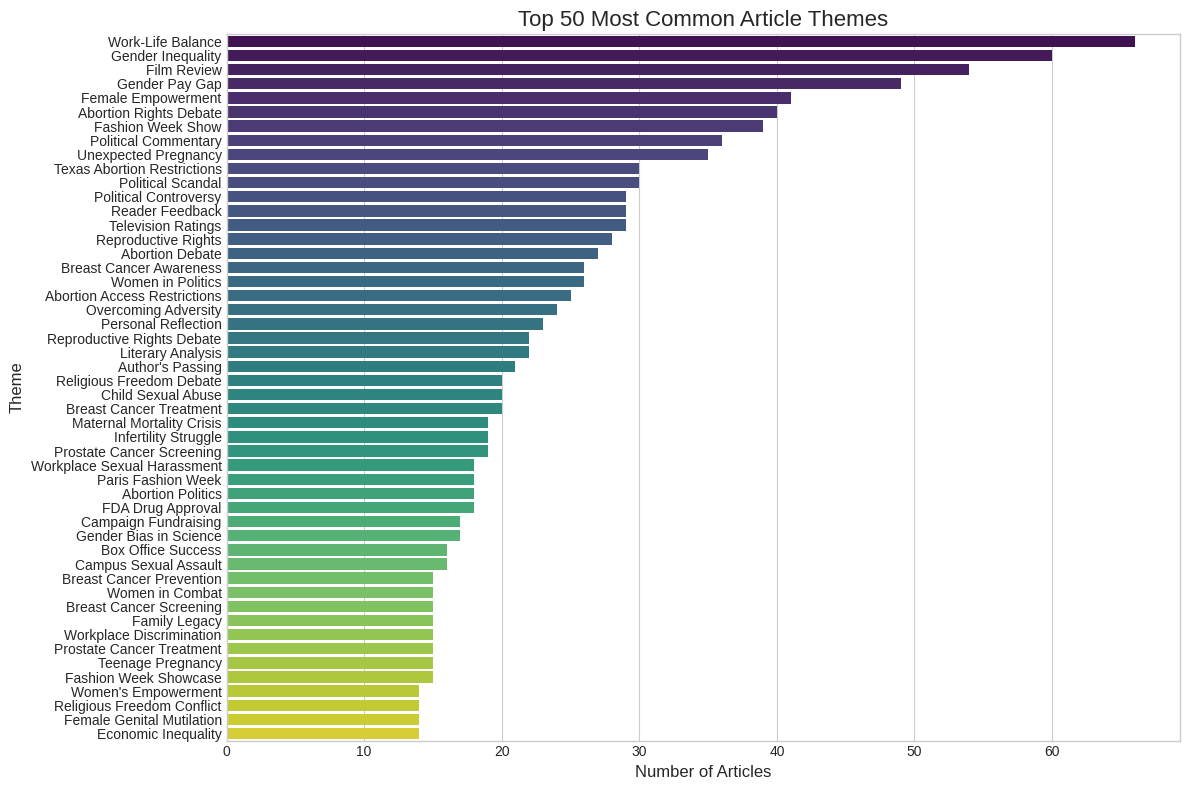

In [4]:
#Theme Analytics

import matplotlib.pyplot as plt
import seaborn as sns


theme_counts = full_df['gemini_theme'].value_counts()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

filtered_theme_counts = theme_counts[~theme_counts.index.str.contains('Obituary|No Theme|Correction', case=False, na=False)]
top_themes = filtered_theme_counts.head(50)

sns.barplot(x=top_themes.values, y=top_themes.index, palette='viridis', hue=top_themes.index,ax=ax)

ax.set_title('Top 50 Most Common Article Themes', fontsize=16)
ax.set_xlabel('Number of Articles', fontsize=12)
ax.set_ylabel('Theme', fontsize=12)

plt.tight_layout()
plt.show()

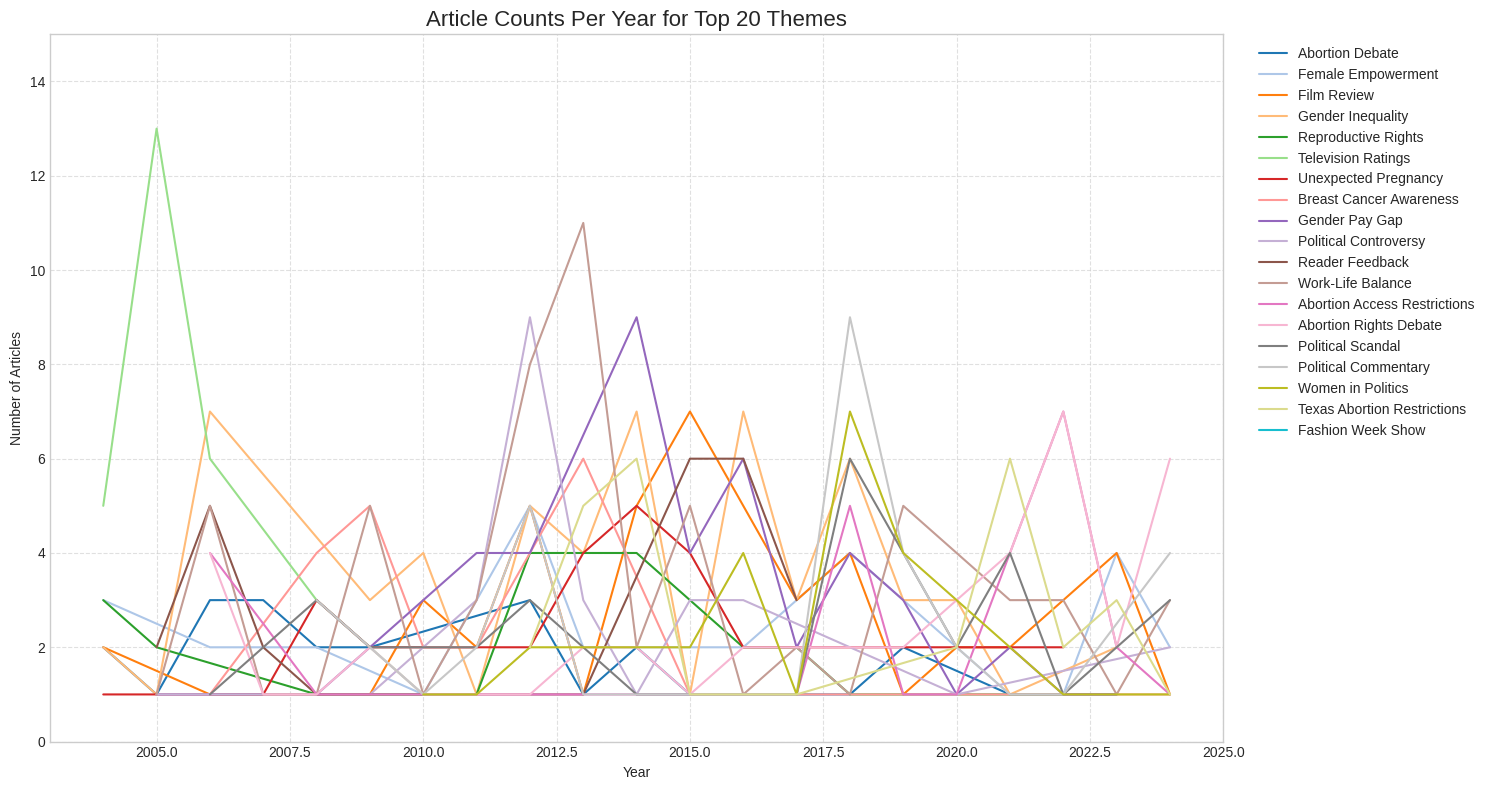

In [21]:
top_20_themes = full_df['gemini_theme'].value_counts().nlargest(20).index
filtered_df = full_df[full_df['gemini_theme'].isin(top_20_themes)]
filtered_df_no_theme = filtered_df[filtered_df['gemini_theme'] != 'No Theme']
yearly_counts = filtered_df_no_theme.groupby(['year', 'gemini_theme']).size().reset_index(name='article_count')


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Create the line plot
sns.lineplot(
    data=yearly_counts,
    x='year',
    y='article_count',
    hue='gemini_theme',
    palette='tab20'
)

# Add title and labels
plt.title('Article Counts Per Year for Top 20 Themes', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.grid(True, linestyle='--', alpha=0.6)

# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylim(0, 15) # Sets the axis to range from 0 to 15

plt.tight_layout() # Adjust layout
plt.show()